# Exploring sentiment analysis on Yelp data

In this notebook, I tried to perform sentiment analysis on the Yelp hotel reviews dataset using 4 techniques. 

* TextBlob
* VADAR
* Using a pre-trained distillBERT model from HuggingFace's transformers
* Training my own NN with a transformer block and embedding layer on Yelp data with TensorFlow.

I also did some experiments with training a Naive Bayes classifier in TextBlob, but there is few documentation on that technique online but I left the codes in here for posterity.

In [230]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import sqlite3
import string
from nltk.sentiment import SentimentIntensityAnalyzer


from textblob import TextBlob
from textblob.classifiers import NaiveBayesClassifier

from transformers import pipeline

import tensorflow 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import precision_score, recall_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

In [95]:

# Read sqlite query results into a pandas DataFrame
con = sqlite3.connect("yelpHotelData.db")
df = pd.read_sql_query("SELECT * from review", con)

# Verify that result of SQL query is stored in the dataframe
print(df.head())

con.close()

        date                reviewID              reviewerID  \
0   6/8/2011            MyNjnxzZVTPq  IFTr6_6NI4CgCVavIL9k5g   
1  8/30/2011  BdD7fsPqHQL73hwENEDT-Q  c_-hF15XgNhlyy_TqzmdaA   
2  6/26/2009                BfhqiyfC  CiwZ6S5ZizAFL5gypf8tLA   
3  9/16/2010                      Ol  nf3q2h-kSQoZK2jBY92FOg   
4   2/5/2010  i4HIAcNTjabdpG1K4F5Q2g  Sb3DJGdZ4Rq__CqxPbae-g   

                                       reviewContent  rating  usefulCount  \
0  Let me begin by saying that there are two kind...       5           18   
1  The only place inside the Loop that you can st...       3            0   
2  I have walked by the Tokyo Hotel countless tim...       5           12   
3  If you are considering staying here, watch thi...       1            8   
4  This place is disgusting, absolutely horrible,...       3           11   

   coolCount  funnyCount flagged                 hotelID  
0         11          28       N  tQfLGoolUMu2J0igcWcoZg  
1          3           4       N  

# Explore the Yelp data

In [96]:
# Get info 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 688329 entries, 0 to 688328
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   date           688329 non-null  object
 1   reviewID       688329 non-null  object
 2   reviewerID     688329 non-null  object
 3   reviewContent  688329 non-null  object
 4   rating         688329 non-null  int64 
 5   usefulCount    688329 non-null  int64 
 6   coolCount      688329 non-null  int64 
 7   funnyCount     688329 non-null  int64 
 8   flagged        688329 non-null  object
 9   hotelID        688329 non-null  object
dtypes: int64(4), object(6)
memory usage: 52.5+ MB


In [97]:
# Remove funny characters
df['reviewContent'] = df['reviewContent'].apply(lambda x: str(x).replace(u'\xa0', u''))
df['reviewContent'] = df['reviewContent'].apply(lambda x: str(x).strip("/"))

In [98]:
# Print to check
print(df.reviewContent[99999])

Stopped by here to meet a friend last night after a long day at the office.  I had no idea that there was a place with such character, around all the characterless places in the area!  All I could think was that I was continuing my fine tradition of being in a dive bar, dressed for business, where my open toe shoes could scoop up the peanut shells on the floor! What can I say? An interesting mix of people from blue collar to white collar to some guy from out of town with his shirt half off and crooning along with the jukebox which I must say had some pretty fine songs!  A little bit of Monk's trivia is that all the light fixtures have been collected from antique stores around the world -which is why they don't match adding to the eclectic feel of the place. Monk's has a large beer selection and while I didn't have any food- my friend's burger looked and smelled great and came with curly fries. Where do you get those anymore these days? It was like an 80's flashback! Another plus? The b

In [99]:
# Create label for the outcome. 
conditions = [
    (df['rating'] < 3),
    (df['rating'] >=  3)]
values = ['neg', 'pos']

# Create label column
df['label'] = np.select(conditions, values)

Before examining the dataset more, I want to split it into a training and test set. I also want a validation set to test the model on to tune my parameters before touching the test set. I decided to count 3/5 as positive because businesses would care more about the truly disastrous cases that resulted in 1 & 2 stars reviews.

In [100]:
df.shape[0]

688329

In [101]:
# Train test split

# Shuffle the data first
df = shuffle(df,random_state=34)

# Reduce the data set to 10000 reviews
df = df[:10000]

# 80% training, 15% validation, 5% test
CUT1=int(0.80*df.shape[0])
CUT2=int((0.80+0.15)*df.shape[0])


train_data, val_data, test_data= df[:CUT1], df[CUT1:CUT2], df[CUT2:]
print('------PARTITION INFO---------')
print("train_data shape:",train_data.shape)
print("val_data shape:"  ,val_data.shape)
print("test_data shape:" ,test_data.shape)


------PARTITION INFO---------
train_data shape: (8000, 11)
val_data shape: (1500, 11)
test_data shape: (500, 11)


# Explore the distribution of the rating in the training set

<AxesSubplot:>

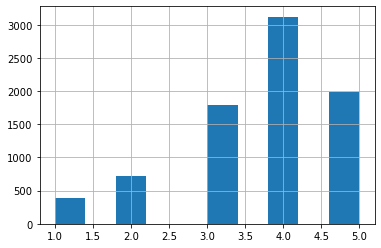

In [29]:
train_data.rating.hist()

From the training data, we could see that reviews skew positive. We will use 3 as the cut off. We will only consider 2 classes: positive (rating>=3) and negative. 

# Make a custom classifier using TextBlob

In [10]:
# # Use the randomized index to split the df
# # Using this tutorial https://textblob.readthedocs.io/en/dev/classifiers.html

# train = list(zip(train_data.reviewContent,train_data.label))
# val = list(zip(val_data.reviewContent,val_data.label))
# test = list(zip(test_data.reviewContent,test_data.label))

In [11]:
# # Example of what the train set looks like
# train[-3]

In [12]:
# # Create a Naive Bayes classifier, passing the training data into the constructor.
# cl = NaiveBayesClassifier(train)

In [13]:
# # Evaluate the classififer on the training set
# cl.accuracy(train)

In [14]:
# # Evaluate the classififer on the validation set
# cl.accuracy(val)

In [15]:
# # Evaluate it on the test set
# cl.accuracy(test)

<!-- The customized classififer does equally well on the validation set and the test set.
 -->

In [16]:
# # Show the most informative features
# cl.show_informative_features(5)  

# TextBlob Sentiment Analysis

In [31]:
# Define a function to get sentiment score from TextBlob
# https://stackoverflow.com/questions/43485469/apply-textblob-in-for-each-row-of-a-dataframe
def sentiment_calc(text):
    try:
        return TextBlob(text).sentiment.polarity
    except:
        return None

In [36]:
# Define function to assign polarity label
def polarity_label(polarity_value):
    if polarity_value < 0:
        lab = 'neg'     
    if polarity_value >= 0:
        lab = 'pos'
    return lab

In [37]:
# Apply the sentiment_calc function on the training set
train_data['blob_polarity'] = train_data.reviewContent.apply(sentiment_calc)


In [38]:
train_data['blob_label'] = train_data.blob_polarity.apply(lambda x: polarity_label(x))

In [39]:
# Print out a few examples
train_data[['reviewContent','rating','label','blob_polarity','blob_label']].head(20)

,reviewContent,rating,label,blob_polarity,blob_label
396284,Went here with my nieces and wife on a thursda...,4,pos,0.407500,pos
48305,This glossy and glassy skyscraper designed by ...,3,pos,0.050000,pos
640273,Came here for a Union League event and this pl...,5,pos,0.292036,pos
385327,I love going to dinner and being able to try a...,4,pos,0.515789,pos
425149,This Ralph's had a decent meat and seafood cou...,2,neg,0.163542,pos
8938,I am so proud to be adding this business! My f...,5,pos,0.397516,pos
645399,"Girl date with my Carrots, and it was decreed ...",4,pos,0.196339,pos
323300,"The food was good, but the service was extreme...",3,pos,0.090064,pos
534126,"Since we were in the area, Ciara G and I decid...",5,pos,0.338818,pos
513676,Nestled in an Asian shopping center near my ap...,3,pos,0.153472,pos


As we expected, because the reviews tend to skew positive, TextBlob gives us overwhelming positive results as well.

In [40]:
print(classification_report(train_data.label, train_data.blob_label))

              precision    recall  f1-score   support

         neg       0.54      0.31      0.40      1104
         pos       0.90      0.96      0.93      6896

    accuracy                           0.87      8000
   macro avg       0.72      0.64      0.66      8000
weighted avg       0.85      0.87      0.85      8000



In [236]:
# Apply the sentiment_calc function on the test set
test_data['blob_polarity'] = test_data.reviewContent.apply(sentiment_calc)
# Apply the polarity_label function:
test_data['blob_label'] = test_data['blob_polarity'].apply(lambda x: polarity_label(x))

print(classification_report(test_data.label, test_data.blob_label))

              precision    recall  f1-score   support

         neg       0.61      0.33      0.43        70
         pos       0.90      0.97      0.93       430

    accuracy                           0.88       500
   macro avg       0.75      0.65      0.68       500
weighted avg       0.86      0.88      0.86       500



Out of the box, the accuracy of TextBlob is 68% on the training set and 70% on the validation set. A business would care more about the negative reviews. In this case, the high precision and low recall score for the negative label (-1) is a good thing. Because we have an imbalanced set where more reviews are positive, the model predicted fewer negative reviews, but most of its predicted negative reviews are correct when compared to the training labels.


# VADAR sentiment Analysis


In [42]:
# Function to use VADAR sentiment
# https://gist.github.com/BenjaminFraser/fc4dd29549a75c93336822060d012ec8

sia = SentimentIntensityAnalyzer()


def vadar_sentiment(text):
    """ Calculate and return the nltk vadar (lexicon method) sentiment """
    return sia.polarity_scores(text)['compound']

In [43]:
# Apply vadar_sentiment on training data
train_data['vadar_polarity'] = train_data['reviewContent'].apply(vadar_sentiment)
# Apply polarity function
train_data['vadar_label'] = train_data.vadar_polarity.apply(lambda x: polarity_label(x))

In [44]:
# Print out a few examples
train_data[['reviewContent','rating','label','vadar_polarity','vadar_label']].head(10)

,reviewContent,rating,label,vadar_polarity,vadar_label
396284,Went here with my nieces and wife on a thursda...,4,pos,0.9577,pos
48305,This glossy and glassy skyscraper designed by ...,3,pos,0.8360,pos
640273,Came here for a Union League event and this pl...,5,pos,0.9757,pos
385327,I love going to dinner and being able to try a...,4,pos,0.9935,pos
425149,This Ralph's had a decent meat and seafood cou...,2,neg,0.8699,pos
8938,I am so proud to be adding this business! My f...,5,pos,0.9982,pos
645399,"Girl date with my Carrots, and it was decreed ...",4,pos,0.9281,pos
323300,"The food was good, but the service was extreme...",3,pos,0.8074,pos
534126,"Since we were in the area, Ciara G and I decid...",5,pos,0.9979,pos
513676,Nestled in an Asian shopping center near my ap...,3,pos,0.5167,pos


In [237]:
# Apply vadar_sentiment on training data
test_data['vadar_polarity'] = test_data['reviewContent'].apply(vadar_sentiment)
# Apply polarity function
test_data['vadar_label'] = test_data.vadar_polarity.apply(lambda x: polarity_label(x))

In [238]:
print(classification_report(test_data.label, test_data.vadar_label))

              precision    recall  f1-score   support

         neg       0.64      0.33      0.43        70
         pos       0.90      0.97      0.93       430

    accuracy                           0.88       500
   macro avg       0.77      0.65      0.68       500
weighted avg       0.86      0.88      0.86       500



# Tranformers - Hugging Face distilBERT

In [142]:
# Initializer pipeline
cls = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english",
               max_length=512, truncation =True)

In [151]:
train_data['bert_label'] = train_data.reviewContent.apply(lambda x: cls(x)[0]['label'])

In [152]:
def relabel(x):
    # Create label for the outcome. 
    conditions = [
        (x['bert_label']  == 'POSITIVE'),
        (x['bert_label'] ==  'NEGATIVE')]
    values = ['pos', 'neg']

    # Create label column
    x['bert_label'] = np.select(conditions, values)
    return x

In [154]:
train_data = relabel(train_data)

In [156]:
print(classification_report(train_data.label, train_data.bert_label))

              precision    recall  f1-score   support

         neg       0.40      0.87      0.55      1106
         pos       0.97      0.79      0.87      6894

    accuracy                           0.80      8000
   macro avg       0.69      0.83      0.71      8000
weighted avg       0.89      0.80      0.83      8000



# Train my own NN with transformer block using keras on the Yelp data

In [198]:
# https://keras.io/examples/nlp/text_classification_with_transformer/

from tensorflow import keras
from tensorflow.keras import layers


In [199]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


In [247]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions


# Redo the train test split

In [265]:
# This came from the book Deep Learning with Python by F. Chollett

maxlen = 200  # We will cut reviews after 100 words

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['reviewContent'])
sequences = tokenizer.texts_to_sequences(df['reviewContent'])
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

Found 37282 unique tokens.


In [266]:
# Redo the train test split
x_train, x_val, x_test= data[:CUT1], data[CUT1:CUT2], data[CUT2:]

In [267]:
# Import label encoder
from sklearn import preprocessing
 
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
 
# Encode outcome labels in column 
df['label']= label_encoder.fit_transform(df['label'])


labels = np.asarray(df.label)
y_train, y_val, y_test = labels[:CUT1], labels[CUT1:CUT2], labels[CUT2:]


In [268]:
# https://keras.io/examples/nlp/text_classification_with_transformer/

embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(2, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)


In [273]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
history = model.fit(
    x_train, y_train, batch_size=32, epochs=50, validation_data=(x_val, y_val))


Epoch 1/50
250/250 [==============================] - 11s 41ms/step - loss: 0.0097 - accuracy: 0.9975 - val_loss: 0.9441 - val_accuracy: 0.8740
Epoch 2/50
250/250 [==============================] - 11s 43ms/step - loss: 0.0044 - accuracy: 0.9985 - val_loss: 1.0846 - val_accuracy: 0.8640
Epoch 3/50
250/250 [==============================] - 11s 42ms/step - loss: 0.0045 - accuracy: 0.9984 - val_loss: 1.0892 - val_accuracy: 0.8773
Epoch 4/50
250/250 [==============================] - 11s 42ms/step - loss: 0.0073 - accuracy: 0.9977 - val_loss: 1.0602 - val_accuracy: 0.8507
Epoch 5/50
250/250 [==============================] - 10s 41ms/step - loss: 0.0035 - accuracy: 0.9987 - val_loss: 1.2456 - val_accuracy: 0.8487
Epoch 6/50
250/250 [==============================] - 10s 41ms/step - loss: 4.4544e-04 - accuracy: 0.9999 - val_loss: 1.2480 - val_accuracy: 0.8740
Epoch 7/50
250/250 [==============================] - 10s 42ms/step - loss: 6.1452e-05 - accuracy: 1.0000 - val_loss: 1.3419 - val_a

In [274]:
model.evaluate(x_test, y_test)

16/16 [==============================] - 0s 16ms/step - loss: 2.5777 - accuracy: 0.8640


[2.5777125358581543, 0.8640000224113464]

In [275]:
# Predict on test set
predictions = model.predict(x_test)
# Convert probabilities to classes
y_pred = np.argmax(predictions, axis=1)

In [276]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.52      0.39      0.44        70
           1       0.90      0.94      0.92       430

    accuracy                           0.86       500
   macro avg       0.71      0.66      0.68       500
weighted avg       0.85      0.86      0.86       500



# Conclusion:

I tried 4 different methods. Reviews tend to skew positive and businesses ideally should focus on correctly identifying the true negatives in reviews so they can identify problems within their operations. Because we're dealing with a classification problem ('positive' or 'negative' review) with imbalanced classes (fewer negative reviews than positive reviews), we should focus on precision & recall when comparing the models. Below are the precision/ recall metrics for the **negative** class for all 4 approaches on the same test set of ~500 reviews

* TextBlob: precision: 0.61  recal: 0.33
* VADAR: precision 0.64 recall: 0.33 
* Using a pre-trained distillBERT: precision: 0.40 recall: 0.87
* training my own NN with a transformer block on Yelp data in using TensorFlow: precision: 0.52 recall: 0.39

From these metrics, using the pre-trained distillBERT seems to be the way to go - the high recall rates means that the model returned a low false negative rate - which means that the negatives that it did pick out were actually negatives. The drawback of distilBERT is that it took my computer (I have a brand new Macbook Pro with the new Apple Silicon M1 Max chip & 10 CPU cores) quite a while to run, but I can see how powerful this technique can be for businesses and policymakers who do not have the capital/ resources to go through each and every review to identify negative customer feedback.